In [13]:
#load in necessary python libraries for this analysis
import pandas as pd
import numpy as np
from scipy import stats
from mlxtend.preprocessing import minmax_scaling
import seaborn as sns
import missingno 
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-ticks')

df = pd.read_csv('titanic.csv')
df.rename(columns={'Pclass': 'Passenger Class'}, inplace=True)
df.head()

,PassengerId,Survived,Passenger Class,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
#get missing value info
missing_values_count = df.isnull().sum()
missing_values_count

PassengerId          0
Survived             0
Passenger Class      0
Name                 0
Sex                  0
Age                177
SibSp                0
Parch                0
Ticket               0
Fare                 0
Cabin              687
Embarked             2
dtype: int64

In [9]:
#most of the cabin data is missing so we will omit this column, as well as Name, passengerId, ticket and fare for
#this investigation as these values will likely have nothing to do with surivivability
#we will make a new data frame in-case we need to access the initial one later

titanic = df.drop(['Cabin','Fare','Name','Ticket','PassengerId'], axis=1)
titanic.head()

,Survived,Passenger Class,Sex,Age,SibSp,Parch,Embarked
0,0,3,male,22.0,1,0,S
1,1,1,female,38.0,1,0,C
2,1,3,female,26.0,0,0,S
3,1,1,female,35.0,1,0,S
4,0,3,male,35.0,0,0,S


In [10]:
titanic.info() 
#there are 177 missing age entries and 2 missing embarked entries. Creating and evaluating a linear regression 
#model to predict and impute the missing data is out of the scope of this analysis so when modelling relationships 
#using these two variables I will omit the rows with missing data and have to use the Available Case Analysis method


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Survived         891 non-null    int64  
 1   Passenger Class  891 non-null    int64  
 2   Sex              891 non-null    object 
 3   Age              714 non-null    float64
 4   SibSp            891 non-null    int64  
 5   Parch            891 non-null    int64  
 6   Embarked         889 non-null    object 
dtypes: float64(1), int64(4), object(2)
memory usage: 48.9+ KB


In [12]:
#change the descriptions of the keys to make them more readable
titanic.loc[:,'Embarked'].replace(['C','S','Q'],['Cherbourg','Southampton','Queenstown'], inplace = True)
titanic.loc[:,'Survived'].replace([0,1],['No','Yes'], inplace = True)
titanic.head()

,Survived,Passenger Class,Sex,Age,SibSp,Parch,Embarked
0,No,3,male,22.0,1,0,Southampton
1,Yes,1,female,38.0,1,0,Cherbourg
2,Yes,3,female,26.0,0,0,Southampton
3,Yes,1,female,35.0,1,0,Southampton
4,No,3,male,35.0,0,0,Southampton


In [23]:
#create a function to return and plot the inputted dataframe column with a bar and pie plot

def one_col_plot(df,col, plt_style = 'seaborn-ticks', color_palette = "coolwarm"):
    ''' Define function to create and plot bar and pie chart based on one column input'''
    gr=pd.DataFrame()
    gr['{} No'.format(col)] = df.groupby(col).size()
    gr['{} Ratio'.format(col)] = np.round(gr['{} No'.format(col)].divide(gr['{} No'.format(col)].sum())*100,0)
    
    print ('Total No. of {}:{}'.format(col,gr['{} No'.format(col)].sum()))
    
    plt.style.use(plt_style)
    sns.set_palette(sns.color_palette(color_palette))
    
    fig=plt.figure()
    plt.axis('off')

    fig.add_subplot(121)
    
    ax=gr['{} No'.format(col)].plot(kind='bar', title='{} Counts'.format(col), figsize=(16,8), color=sns.color_palette())
    _ = plt.setp(ax.get_xticklabels(), rotation=0)
    for p in ax.patches: ax.annotate(np.round(p.get_height(),decimals=2),
                                     (p.get_x()+p.get_width()/2., p.get_height()),
                                     ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    ax.get_yaxis().set_ticks([])
    plt.xlabel('')

    fig.add_subplot(122)
    plt.axis('off')
    gr.loc[:,'{} Ratio'.format(col)].plot(kind= 'pie',
                                     autopct='%1.1f%%',shadow=False,
                                     title='{} Ratio'.format(col), legend=False, labels=None);
    sns.despine(top=True, right=True, left=True, bottom=False);

Total No. of Survived:891


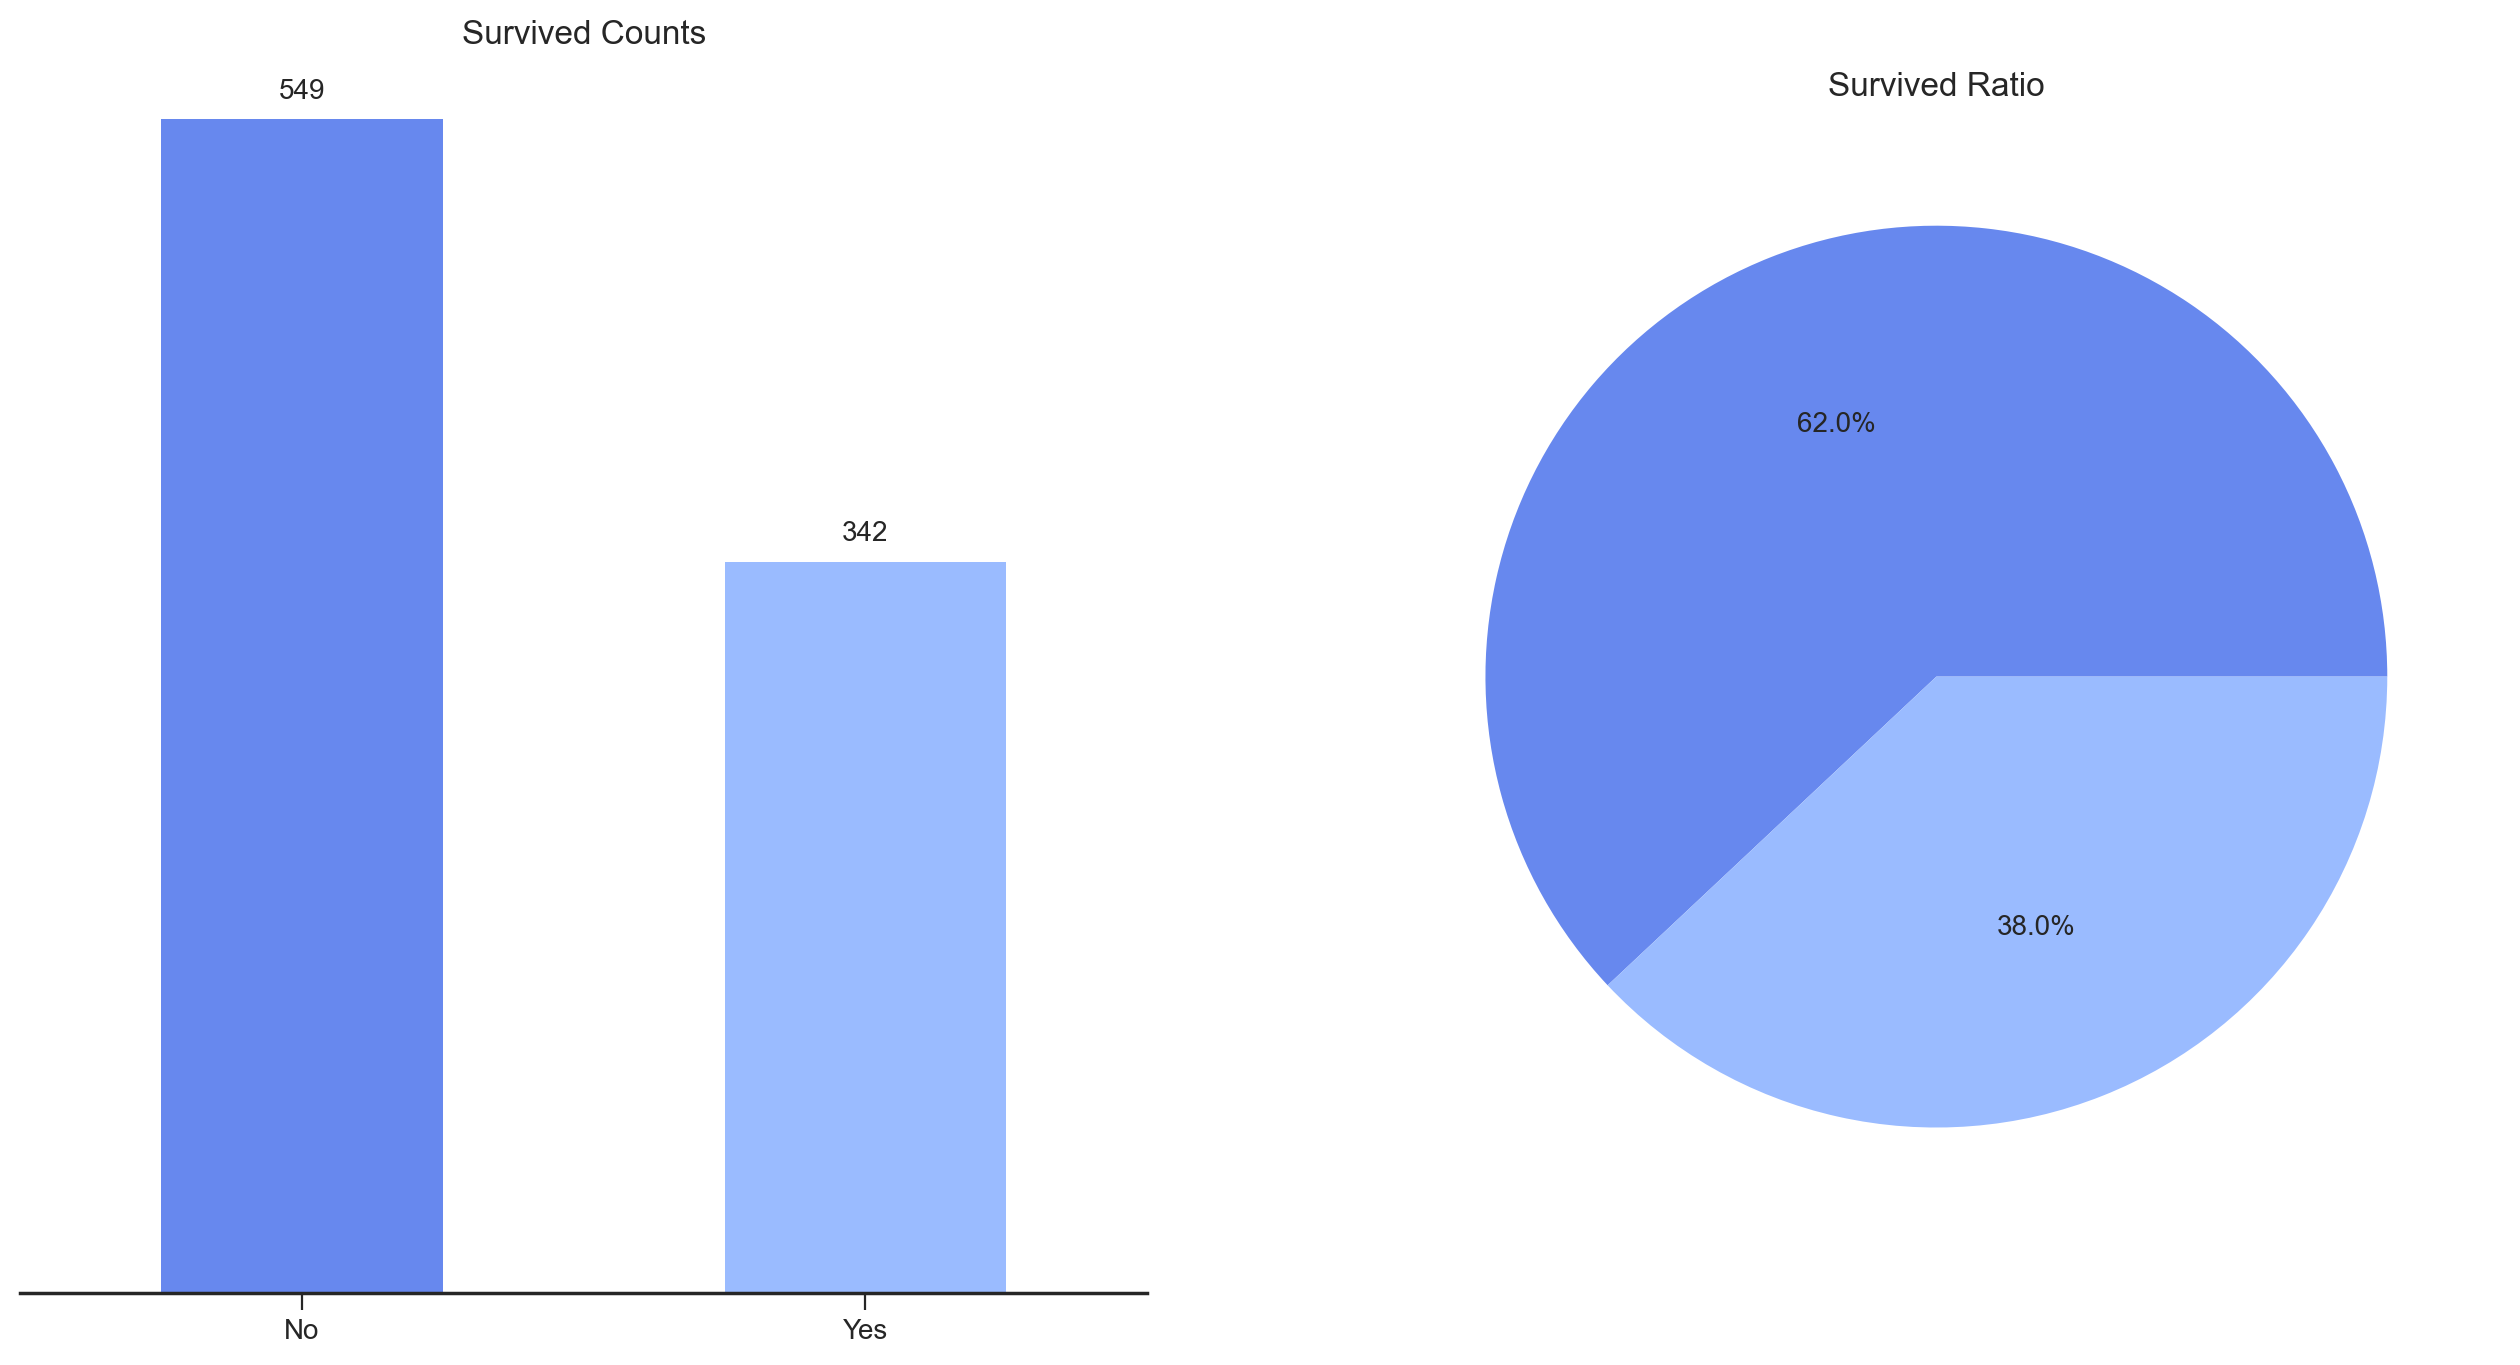

In [24]:
#create bar and pie chart to show ratio of survivors to non-survivors 
#as you can see 549 out of the 891 passengers of this data-set didn't survive. Now lets analyse some of the other
#variables to see which of them had the biggest impact on survivability
one_col_plot(titanic, 'Survived')

Total No. of Embarked:889


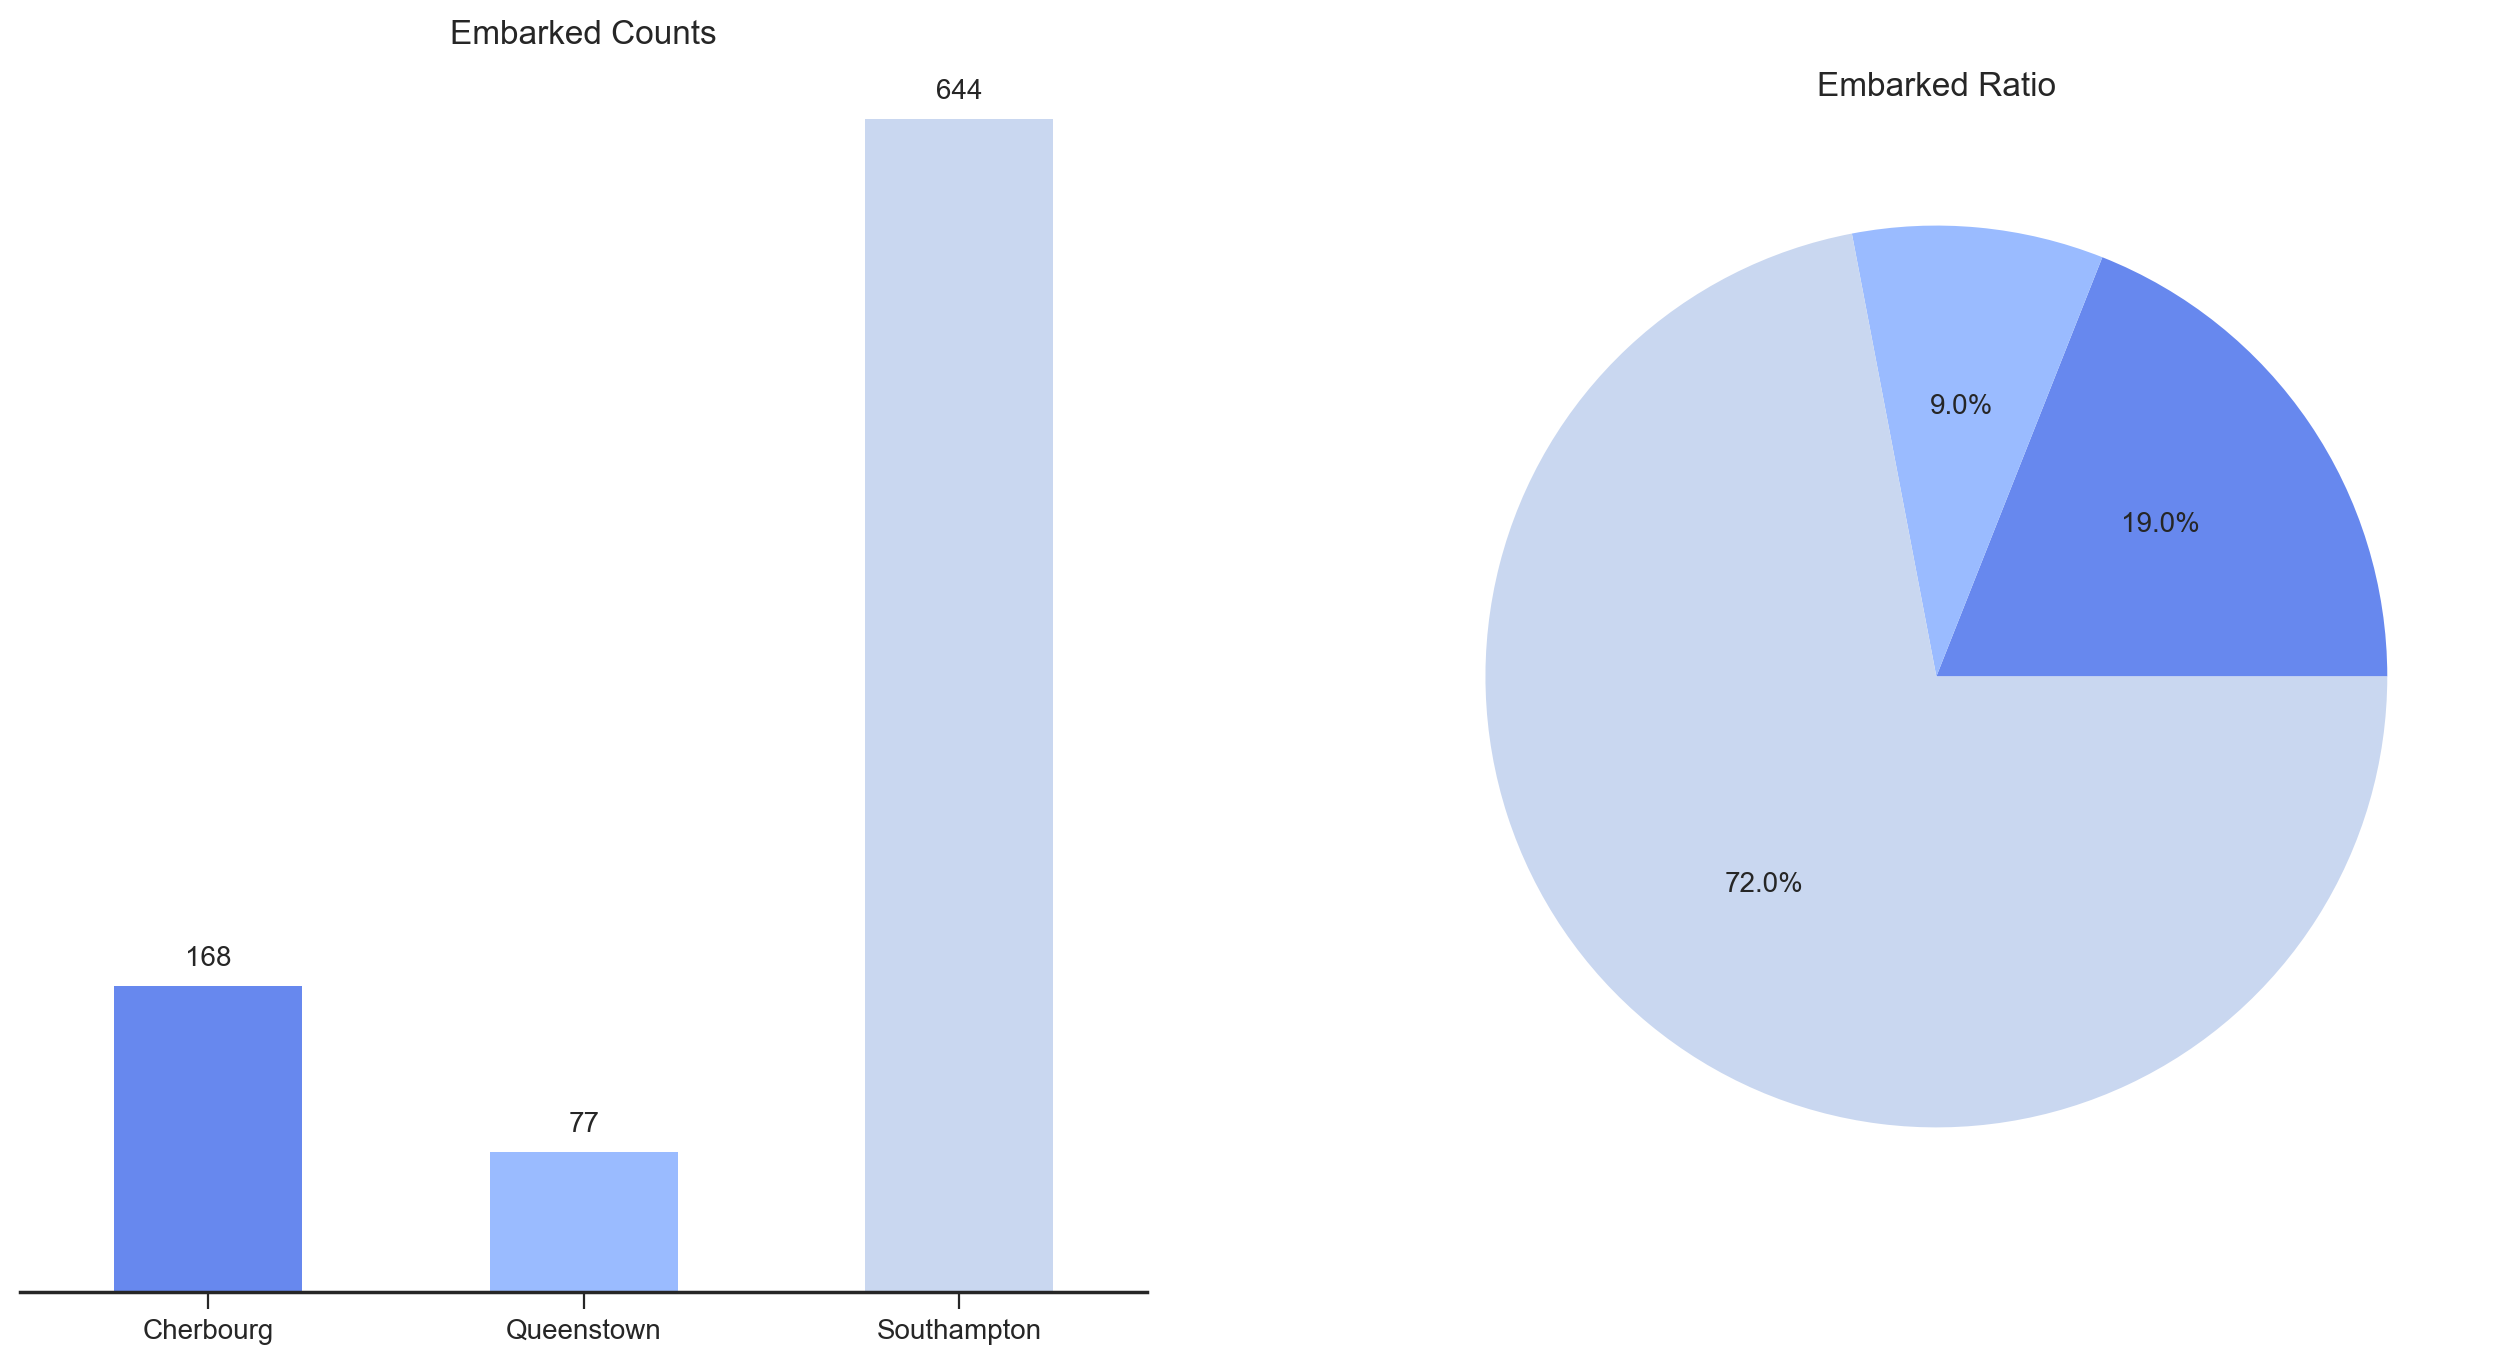

In [25]:
#First lets look at where most of the passengers embarked
#72% of the passengers in this data-set embarked at Southampton, while only 19% embarked at Queenstown
#lets see whether or not the embarking location had an affect on survivability
one_col_plot(titanic, 'Embarked')

In [28]:
#create function to name and 
def plot(table, legloc='upper right',
                                    plt_style = 'seaborn-ticks',
                                    color_palette="dark",sorter=None, stacked=False,
                                    kind = 'bar', percentage = True,
                               custom_title=None, minimal=True, figsize=(19,10), width=0.7 ):     
    grouped = table
    
    #Tranform to percentages
    if percentage == True:
        grouped = np.round(grouped.divide(grouped['Total'],axis=0)*100,0)
    try:   
        del grouped['Total']
    except:
        pass
    
    # rearrange the columns
    if sorter:
        grouped = grouped[sorter]

    plt.style.use(plt_style)
    sns.set_palette(sns.color_palette(color_palette))
    ax = grouped.plot(kind=kind,stacked=stacked, figsize=figsize, width=width)
    _ = plt.setp(ax.get_xticklabels(), rotation=0)  # Rotate labels
    plt.legend(loc=legloc) # plot the legend normally
    
    #annotate the bars
    if percentage == True:
      for p in ax.patches:
            ax.annotate('{}%'.format(int(np.round(p.get_height(),decimals=2))),
                                         (p.get_x()+p.get_width()/2.,
                                          p.get_height()), ha='center', va='center',
                                        xytext=(0, 10), textcoords='offset points')
    else:
      for p in ax.patches:
            ax.annotate(np.round(p.get_height(),decimals=2),
                                         (p.get_x()+p.get_width()/2.,
                                          p.get_height()), ha='center', va='center',
                                        xytext=(0, 10), textcoords='offset points')
    if minimal == True:
        ax.get_yaxis().set_ticks([])
        plt.xlabel('')
        sns.despine(top=True, right=True, left=True, bottom=False);
    else:
        pass     
    # set custom title   
    plt.title(custom_title)

#create function to return and plot bar chart based on two column input
def two_col_plot(df, col1, col2, legloc='upper right',
                                    plt_style = 'ggplot',
                                    color_palette="dark",sorter=None, stacked=False,
                                    kind = 'bar', percentage = True,
                               custom_title=None, minimal=True, figsize=(14,6), width=0.6):   
    
    #Group by Placement and Representative and unstack by Placement
    grouped = df.groupby([col2,col1]).size().unstack(col2)
    
    #Make a totals column sort and delete after
    grouped['Total'] = grouped.sum(axis=1)
    #grouped = grouped.sort_values('Total', ascending = False)
   
    plot(grouped, legloc=legloc,
                                    plt_style = plt_style,
                                    color_palette=color_palette,sorter=sorter, stacked=stacked,
                                    kind = kind , percentage = percentage,
                               custom_title=custom_title, minimal=minimal, figsize=figsize, width=width) 

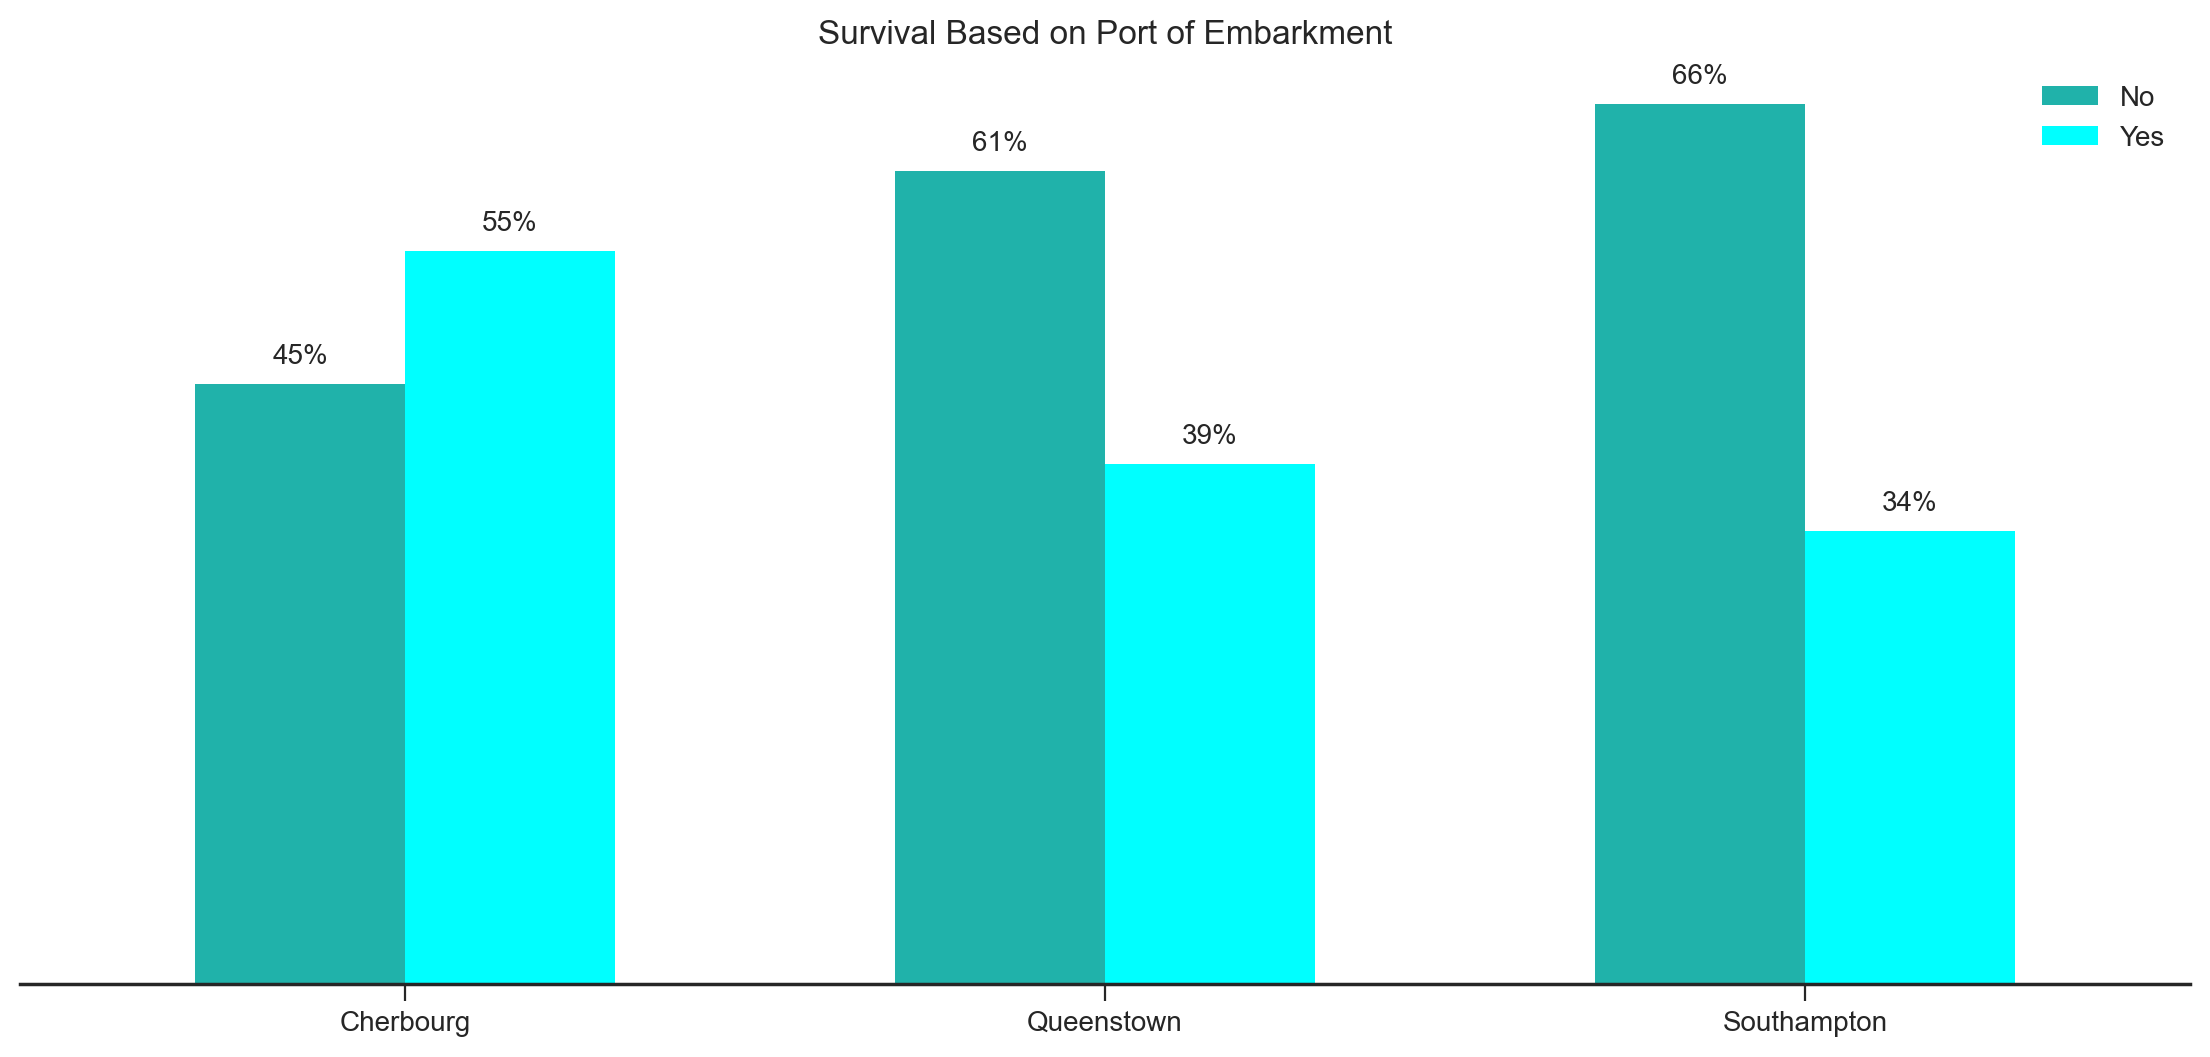

In [33]:
#as you can see 55% of passengers that embarked at Cherbourg survived compared to only 39% and 34% and 
#Queenstown and Southamptom
two_col_plot(titanic, 'Embarked','Survived',color_palette=('lightseagreen','cyan'),
            plt_style = 'seaborn-ticks', custom_title='Survival Based on Port of Embarkment')

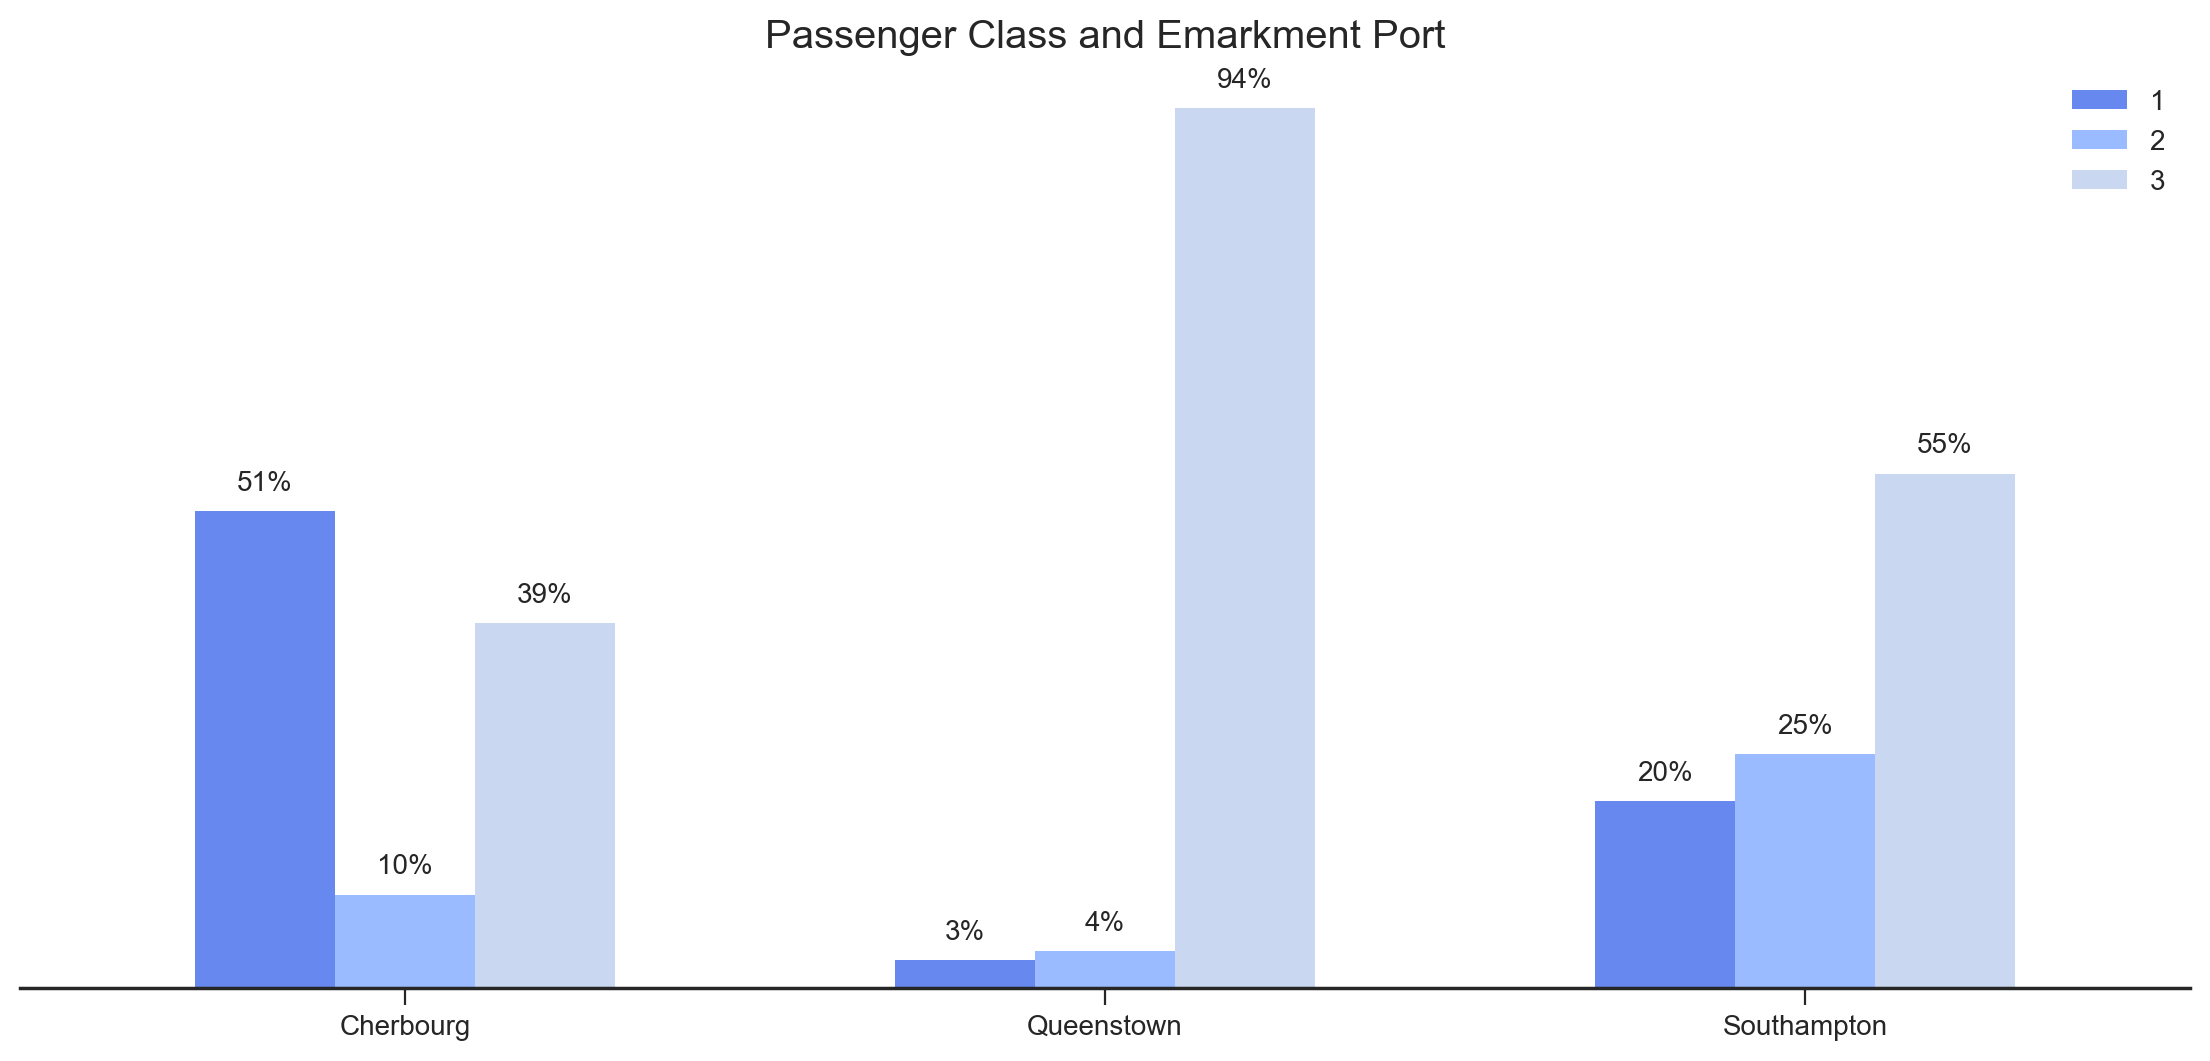

In [38]:
#lets analyse these results futher and see the difference in Passenger Class and Embarkment Port
two_col_plot(titanic,'Embarked','Passenger Class', color_palette='coolwarm', plt_style = 'seaborn-ticks', custom_title = 'Passenger Class and Emarkment Port')

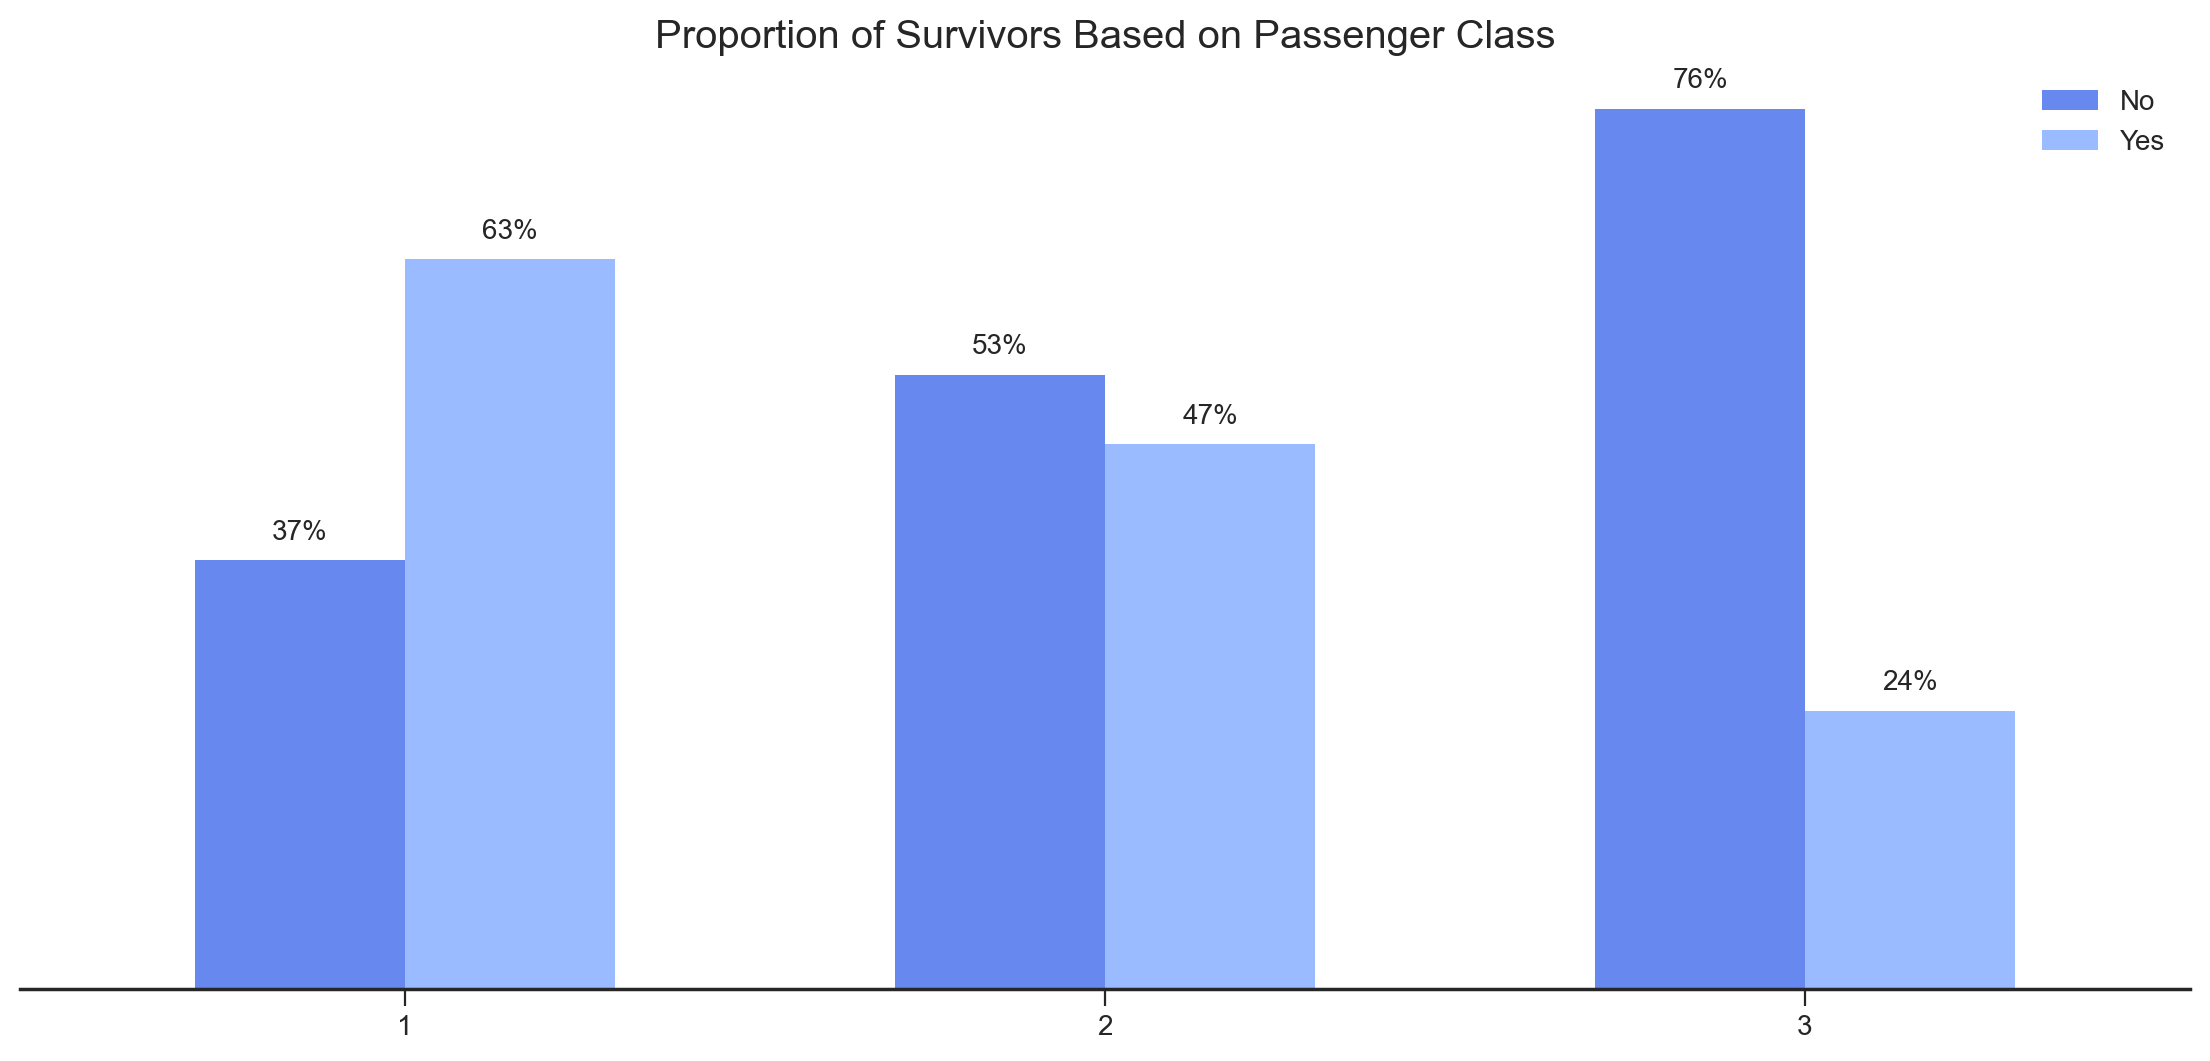

In [40]:
#it looks like Passenger class may have something to do with survivability. A higher percentage of passengers
#boarding at Cherbourg were 1st Class compared to Queenstown and Southampton, which might suggest why a higher
#proportion of the passengers that boarded at Cherbourg Survived 
#lets look at the correlation of survivors which their class 
two_col_plot(titanic,'Passenger Class','Survived', color_palette='coolwarm', plt_style='seaborn-ticks',custom_title = 'Proportion of Survivors Based on Passenger Class')

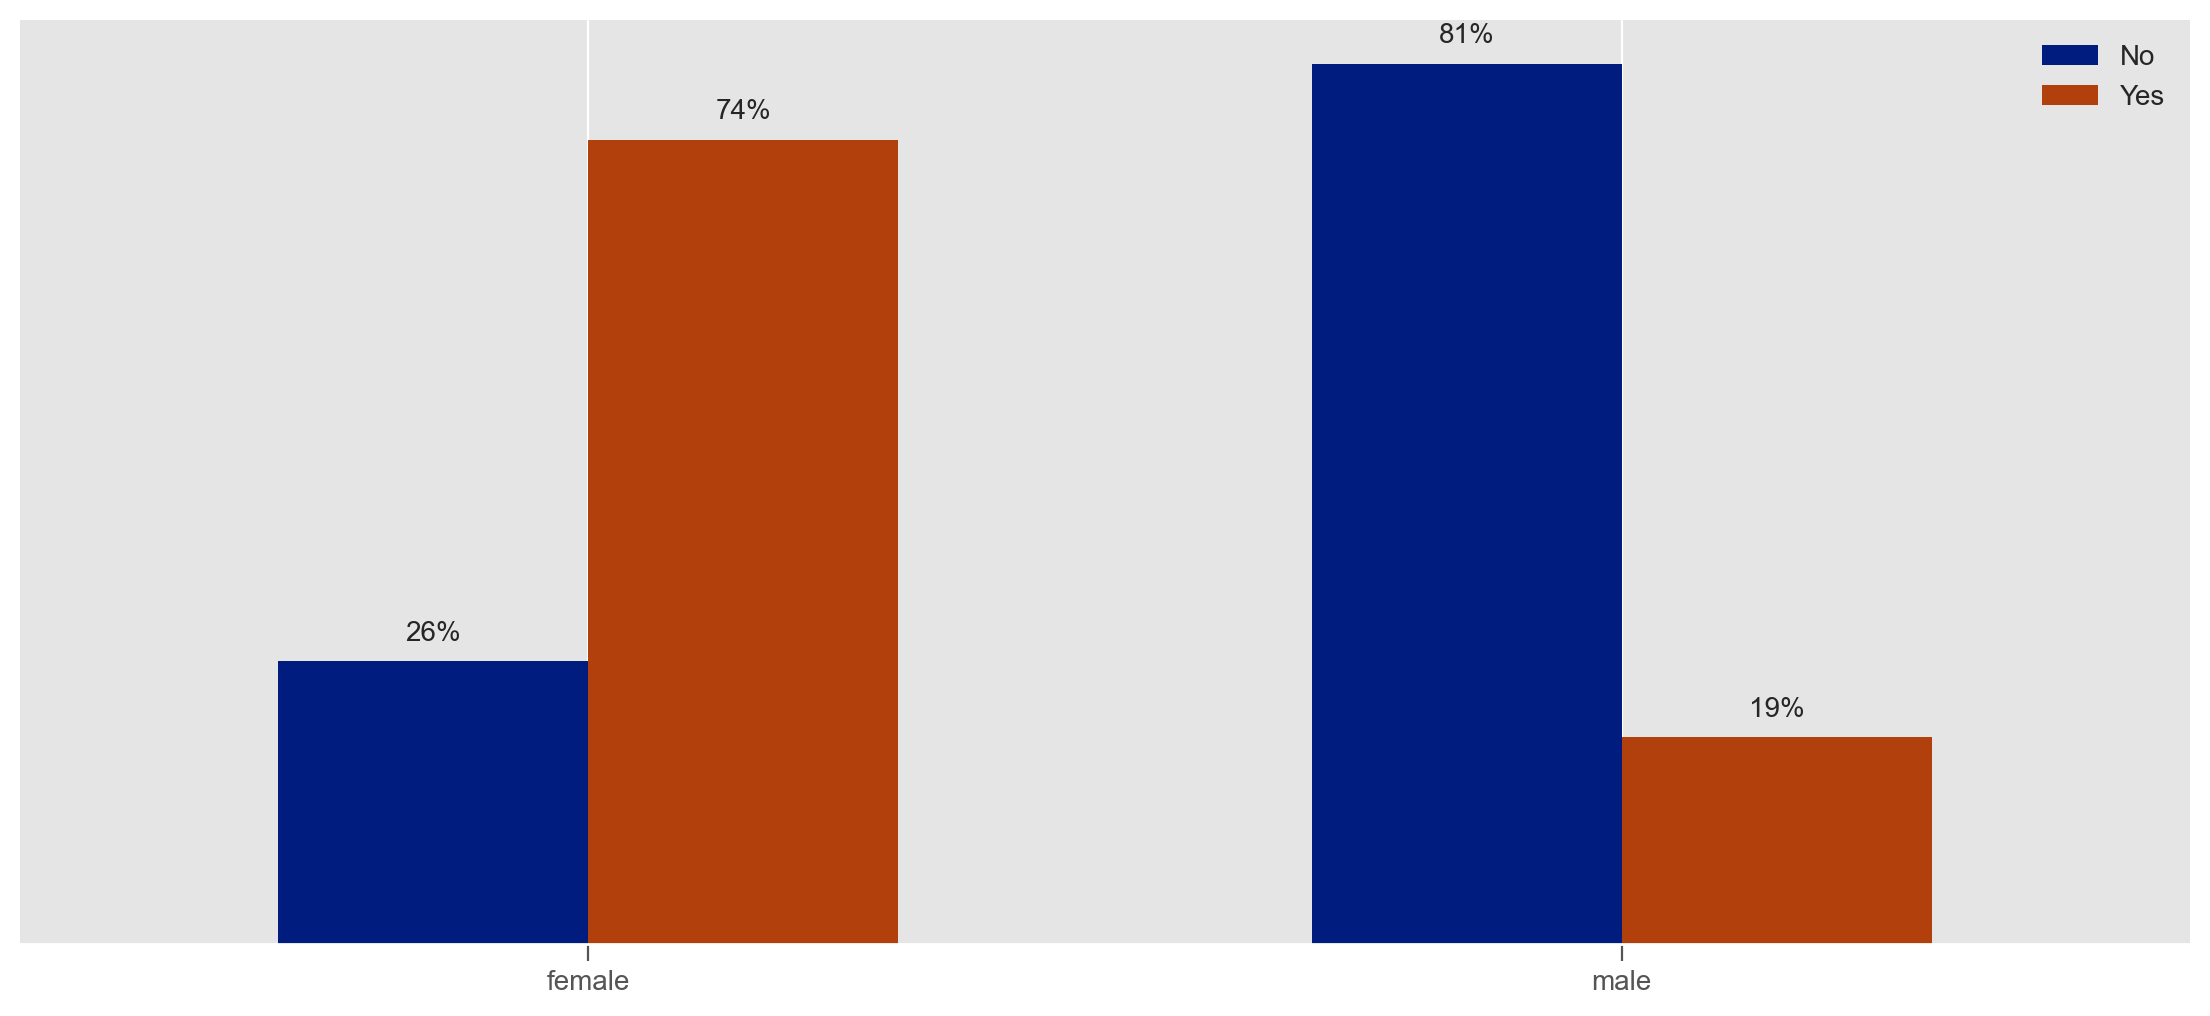

In [43]:
#63% of passengers in 1st class survived compared to 47% and 24% for 2nd and 3rd class respectively.
#This suggests then that like in the movie, 1st class passengers were given priority to the lifeboats
#lets see the proportion of survivors based on their gender
two_col_plot(titanic,'Sex','Survived')
#from the graph you can see that only 19% of men survived the sinking compared to 74% of woman, this suggests that
#women also had priority of the lifeboats

In [53]:
#lets examine the age distribution of passengers and how age affect their chances of survival 
#make a dataframe for all the not missing 'Age' values
#as you can see there a 714 not mssing values for age
age_remaining = titanic[(titanic['Age'].notnull())]
age_remaining

,Survived,Passenger Class,Sex,Age,SibSp,Parch,Embarked
0,No,3,male,22.0,1,0,Southampton
1,Yes,1,female,38.0,1,0,Cherbourg
2,Yes,3,female,26.0,0,0,Southampton
3,Yes,1,female,35.0,1,0,Southampton
4,No,3,male,35.0,0,0,Southampton
...,...,...,...,...,...,...,...
885,No,3,female,39.0,0,5,Queenstown
886,No,2,male,27.0,0,0,Southampton
887,Yes,1,female,19.0,0,0,Southampton
889,Yes,1,male,26.0,0,0,Cherbourg


/Applications/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Age', ylabel='Density'>

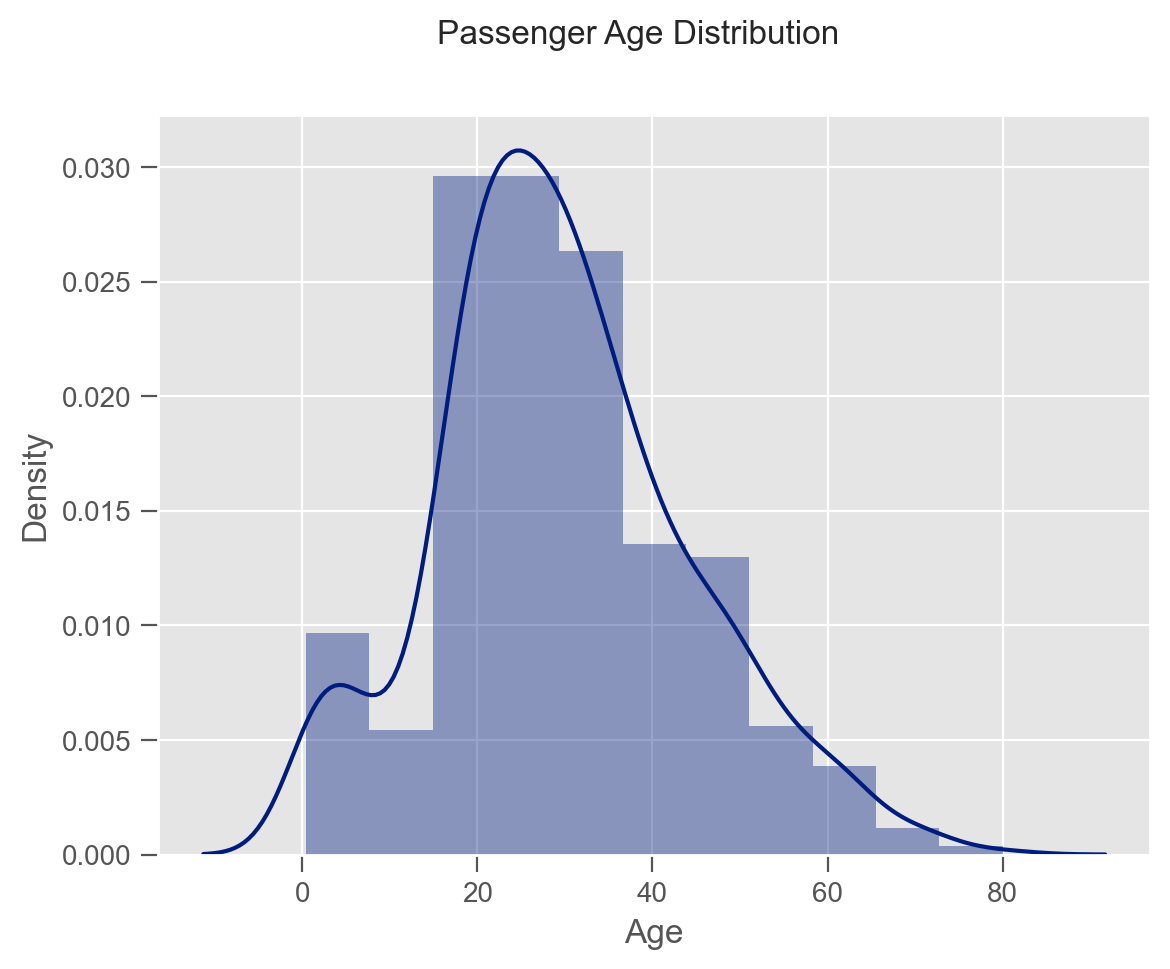

In [54]:
#using the non-missing data create a distplot to display passenger age distribution
ax=plt.figure()
plt.suptitle('Passenger Age Distribution')
sns.distplot(age_remaining['Age'],bins=11)

In [59]:
# Get a summary of the descriptive age stats
v = pd.DataFrame(age_remaining['Age'].describe())
#Change the label titles and round the results
v.index = ['Population Size', 'Mean', 'Std. Deviation', 'Min Age', 'First Quartile', 'Median',\
               'Third Quartile', 'Max Age']
v = v.round(decimals = 2)
v

,Age
Population Size,714.00
Mean,29.70
Std. Deviation,14.53
Min Age,0.42
First Quartile,20.12
Median,28.00
Third Quartile,38.00
Max Age,80.00


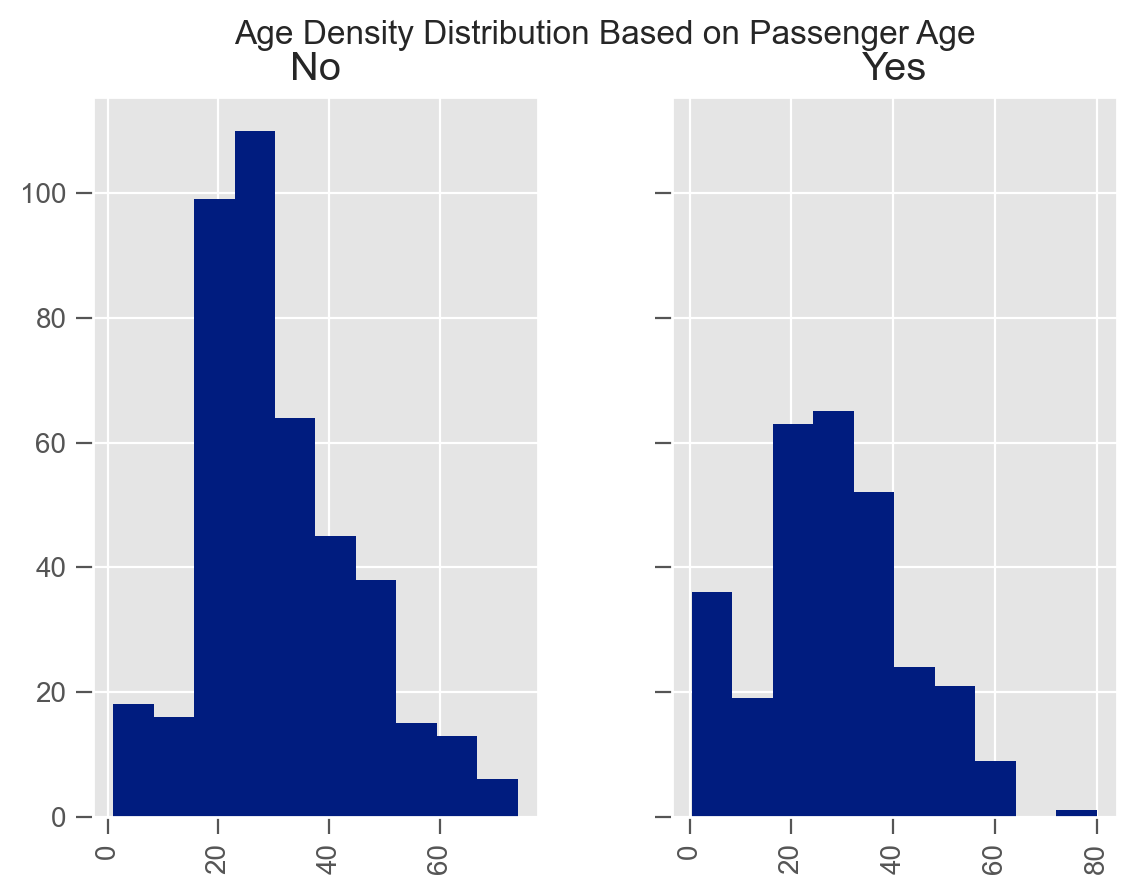

In [68]:
# Next we will get the density distribubtion of survivors based on their age
age_remaining.hist(column="Age",by="Survived", sharey = True)
plt.suptitle('Age Density Distribution Based on Passenger Age');
#As you can see a high percentage of children below 10 survived and almost no-one over 65 survived. This suggests
#that perhaps the women and children first rule did have an effect passenger survivability.

In [69]:
###To conclude - It seems the most important factor in surviving the titanic disaster was passenger class. 
#So it seems like like in the movie, 1st class passengers were given priority of the life-boats. Looking at the data
# you can also see that a higher propoortion of women and younger children survived the incident than you might 
#initially expect. This suggests the the 'women and children first' rule did play an important part in saving
# these more vulnerable lives.

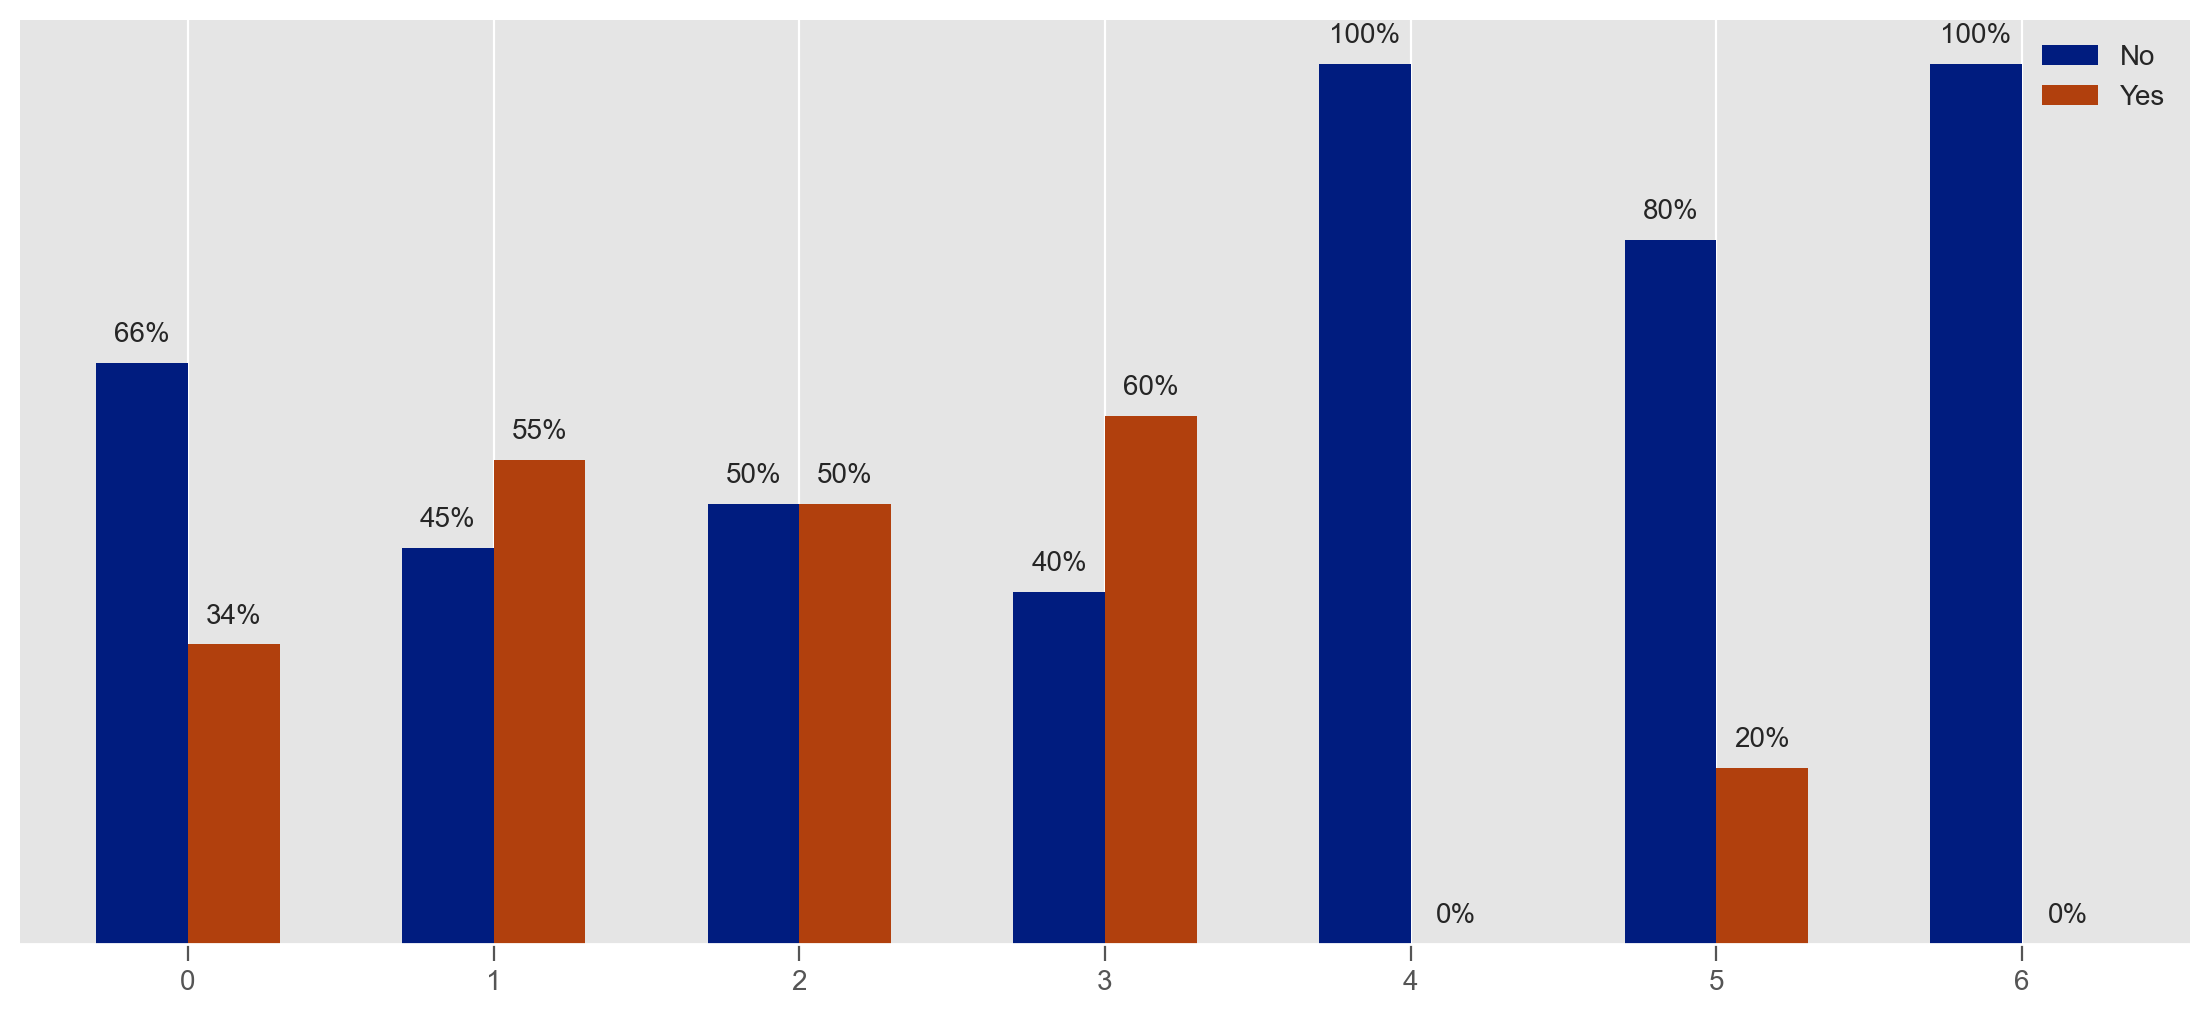

In [74]:
two_col_plot(titanic, 'Parch','Survived')
#One extra observation that can be made from the dataset is that passengers that had smaller families, this is what
#the Parch column shows; 'Parents and Children', had a higher chance of surviving the disaster. This could be because
#in the chaos of the disaster it would have been much harder to make sure all of the family were together and safe
#if there more members to look out for. As you can see from the graph below, once the family size gets above 3
#members, the chance of survival drops to zero.